In [1]:
from openbox import space as sp
import numpy as np
import matplotlib.pyplot as plt
import openbox.surrogate
from openbox.surrogate.base.base_model import AbstractModel
from openbox.acquisition_function import AbstractAcquisitionFunction, EI
from openbox import Advisor
from scipy import stats
from openbox import logger
norm = stats.norm
import so_benchmark_function as sof
import soc_benchmark_function as socf
from openbox import Optimizer
from openbox import logger
from openbox.utils.util_funcs import deprecate_kwarg
from openbox.utils.history import History
from openbox.utils.samplers import SobolSampler, LatinHypercubeSampler, HaltonSampler
from openbox.utils.multi_objective import NondominatedPartitioning
from openbox.utils.early_stop import EarlyStopAlgorithm, EarlyStopException
from openbox.core.base import build_acq_func, build_surrogate
from openbox.acq_optimizer import build_acq_optimizer
from openbox.core.base_advisor import BaseAdvisor

In [2]:
class myAdvisor(BaseAdvisor):
    """
    Generic Bayesian optimization advisor.

    Parameters
    ----------
    config_space : openbox.space.Space or ConfigSpace.ConfigurationSpace
        Configuration space.
    num_objectives : int, default=1
        Number of objectives in objective function.
    num_constraints : int, default=0
        Number of constraints in objective function.
    initial_trials : int, default=3
        Number of initial iterations of optimization.
    init_strategy : str, default='random_explore_first'
        Strategy to generate configurations for initial iterations.
        - 'random_explore_first' (default): Random sampled configs with maximized internal minimum distance
        - 'random': Random sampling
        - 'default': Default configuration + random sampling
        - 'sobol': Sobol sequence sampling
        - 'latin_hypercube': Latin hypercube sampling
    initial_configurations : List[Configuration], optional
        If provided, the initial configurations will be evaluated in initial iterations of optimization.
    transfer_learning_history : List[History], optional
        Historical data for transfer learning.
    rand_prob : float, default=0.1
        Probability to sample random configurations.
    surrogate_type : str, default='auto'
        Type of surrogate model in Bayesian optimization.
        - 'gp' (default): Gaussian Process. Better performance for mathematical problems.
        - 'prf': Probability Random Forest. Better performance for hyper-parameter optimization (HPO).
        - 'lightgbm': LightGBM.
    acq_type : str, default='auto'
        Type of acquisition function in Bayesian optimization.
        For single objective problem:
        - 'ei' (default): Expected Improvement
        - 'eips': Expected Improvement per Second
        - 'logei': Logarithm Expected Improvement
        - 'pi': Probability of Improvement
        - 'lcb': Lower Confidence Bound
        For single objective problem with constraints:
        - 'eic' (default): Expected Constrained Improvement
        For multi-objective problem:
        - 'ehvi (default)': Expected Hypervolume Improvement
        - 'mesmo': Multi-Objective Max-value Entropy Search
        - 'usemo': Multi-Objective Uncertainty-Aware Search
        - 'parego': ParEGO
        For multi-objective problem with constraints:
        - 'ehvic' (default): Expected Hypervolume Improvement with Constraints
        - 'mesmoc': Multi-Objective Max-value Entropy Search with Constraints
    acq_optimizer_type : str, default='auto'
        Type of optimizer to maximize acquisition function.
        - 'local_random' (default): Interleaved Local and Random Search
        - 'random_scipy': L-BFGS-B (Scipy) optimizer with random starting points
        - 'scipy_global': Differential Evolution
        - 'cma_es': Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
    ref_point : List[float], optional
        Reference point for calculating hypervolume in multi-objective problem.
        Must be provided if using EHVI based acquisition function.
    early_stop: bool, default=False
        Whether to enable early stop.
    early_stop_kwargs : dict, optional
        Options for early stop algorithm:
        - min_iter : int
            Minimum number of iterations before early stop is considered.
        - min_improvement_percentage : float
            The minimum improvement percentage. If the Expected Improvement (EI) is less than
            `min_improvement_percentage * (default_obj_value - best_obj_value)`, early stop is triggered.
            If `improvement_threshold` is 0, this criterion is disabled.
        - max_no_improvement_rounds : int
            The maximum tolerable rounds with no improvement before early stop.
            If `max_no_improvement_rounds` is 0, this criterion is disabled.
    output_dir : str, default='logs'
        Directory to save log files. If None, no log files will be saved.
    task_id : str, default='OpenBox'
        Task identifier.
    random_state : int
        Random seed for RNG.
    logger_kwargs : dict, optional
        Additional keyword arguments for logger.
    """

    @deprecate_kwarg("num_objs", "num_objectives", "a future version")
    def __init__(
        self,
        config_space,
        num_objectives=1,
        num_constraints=0,
        initial_trials=3,
        initial_configurations=None,
        init_strategy="random_explore_first",
        transfer_learning_history=None,
        rand_prob=0.1,
        optimization_strategy="bo",
        surrogate_type="auto",
        acq_type="auto",
        acq_optimizer_type="auto",
        ref_point=None,
        early_stop=False,
        early_stop_kwargs=None,
        output_dir="logs",
        task_id="OpenBox",
        random_state=None,
        logger_kwargs: dict = None,
        grad_func=None,
        **kwargs,
    ):
        super().__init__(
            config_space=config_space,
            num_objectives=num_objectives,
            num_constraints=num_constraints,
            ref_point=ref_point,
            output_dir=output_dir,
            task_id=task_id,
            random_state=random_state,
            logger_kwargs=logger_kwargs,
        )

        # Basic components in Advisor.
        self.rand_prob = rand_prob
        self.optimization_strategy = optimization_strategy

        # Init the basic ingredients in Bayesian optimization.
        self.transfer_learning_history = transfer_learning_history
        self.surrogate_type = surrogate_type
        self.constraint_surrogate_type = None
        self.acq_type = acq_type
        self.acq_optimizer_type = acq_optimizer_type

        # initial design
        self.init_num = initial_trials
        self.init_strategy = init_strategy
        if initial_configurations is not None and len(initial_configurations) > 0:
            self.initial_configurations = initial_configurations
            self.init_num = len(initial_configurations)
        else:
            self.initial_configurations = self.create_initial_design(self.init_strategy)
            self.init_num = len(self.initial_configurations)

        # early stop
        self.early_stop = early_stop
        early_stop_kwargs = early_stop_kwargs or dict()
        self.early_stop_algorithm = (
            EarlyStopAlgorithm(**early_stop_kwargs) if self.early_stop else None
        )
        if self.early_stop:
            logger.info(f"Early stop is enabled.")

        self.surrogate_model = None
        self.constraint_models = None
        self.acquisition_function = None
        self.acq_optimizer = None
        self.auto_alter_model = False
        self.algo_auto_selection()
        self.check_setup()
        self.setup_bo_basics()
        self.grad_func = grad_func

    def algo_auto_selection(self):
        from ConfigSpace import (
            UniformFloatHyperparameter,
            UniformIntegerHyperparameter,
            CategoricalHyperparameter,
            OrdinalHyperparameter,
        )

        # analyze config space
        cont_types = (UniformFloatHyperparameter, UniformIntegerHyperparameter)
        cat_types = (CategoricalHyperparameter, OrdinalHyperparameter)
        n_cont_hp, n_cat_hp, n_other_hp = 0, 0, 0
        for hp in self.config_space.get_hyperparameters():
            if isinstance(hp, cont_types):
                n_cont_hp += 1
            elif isinstance(hp, cat_types):
                n_cat_hp += 1
            else:
                n_other_hp += 1
        n_total_hp = n_cont_hp + n_cat_hp + n_other_hp

        info_str = ""

        if self.surrogate_type == "auto":
            use_tl = self.transfer_learning_history is not None
            self.auto_alter_model = True if not use_tl else False
            if n_total_hp >= 100:
                self.optimization_strategy = "random"
                self.surrogate_type = "prf"  # for setup procedure
            elif n_total_hp >= 10:
                self.surrogate_type = "prf" if not use_tl else "tlbo_rgpe_prf"
            elif n_cat_hp > n_cont_hp:
                self.surrogate_type = "prf" if not use_tl else "tlbo_rgpe_prf"
            else:
                self.surrogate_type = "gp" if not use_tl else "tlbo_rgpe_gp"
            info_str += " surrogate_type: %s." % self.surrogate_type

        if self.acq_type == "auto":
            if self.num_objectives == 1:  # single objective
                if self.num_constraints == 0:
                    self.acq_type = "ei"
                else:  # with constraints
                    self.acq_type = "eic"
            elif self.num_objectives <= 4:  # multi objective (<=4)
                if self.num_constraints == 0:
                    self.acq_type = "ehvi"
                else:  # with constraints
                    self.acq_type = "ehvic"
            else:  # multi objective (>4)
                if self.num_constraints == 0:
                    self.acq_type = "mesmo"
                else:  # with constraints
                    self.acq_type = "mesmoc"
                self.surrogate_type = "gp_rbf"
                info_str = " surrogate_type: %s." % self.surrogate_type
            info_str += " acq_type: %s." % self.acq_type

        if self.acq_optimizer_type == "auto":
            if (
                n_cat_hp + n_other_hp == 0
            ):  # todo: support constant hp in scipy optimizer
                self.acq_optimizer_type = "random_scipy"
            else:
                self.acq_optimizer_type = "local_random"
            info_str += " acq_optimizer_type: %s." % self.acq_optimizer_type

        if info_str != "":
            info_str = "[BO auto selection] " + info_str
            logger.info(info_str)

    def alter_model(self, history: History):
        if not self.auto_alter_model:
            return

        num_config_evaluated = len(history)

        if num_config_evaluated >= 300:
            if self.surrogate_type == "gp":
                self.surrogate_type = "prf"
                logger.info(
                    f"n_observations={num_config_evaluated}, change surrogate model from GP to PRF!"
                )
                if self.acq_optimizer_type == "random_scipy":
                    self.acq_optimizer_type = "local_random"
                    logger.info(
                        f"n_observations={num_config_evaluated}, "
                        f"change acq optimizer from random_scipy to local_random!"
                    )
                self.setup_bo_basics()

    def check_setup(self):
        """
        Check optimization_strategy, num_objectives, num_constraints, acq_type, surrogate_type.
        Returns
        -------
        None
        """
        assert self.optimization_strategy in ["bo", "random"]
        assert isinstance(self.num_objectives, int) and self.num_objectives >= 1
        assert isinstance(self.num_constraints, int) and self.num_constraints >= 0

        # single objective
        if self.num_objectives == 1:
            if self.num_constraints == 0:
                assert self.acq_type in [
                    "ei",
                    "eips",
                    "logei",
                    "pi",
                    "lcb",
                    "lpei",
                ]
            else:  # with constraints
                assert self.acq_type in [
                    "eic",
                ]
                if self.constraint_surrogate_type is None:
                    self.constraint_surrogate_type = "gp"

        # multi-objective
        else:
            if self.num_constraints == 0:
                assert self.acq_type in ["ehvi", "mesmo", "usemo", "parego"]
                if self.acq_type == "ehvi" and self.num_objectives > 4:
                    logger.warning(
                        "Computational cost of EHVI with more than 4 objectives might be extremely high!"
                    )
                if self.acq_type == "mesmo" and self.surrogate_type != "gp_rbf":
                    self.surrogate_type = "gp_rbf"
                    logger.warning(
                        "Surrogate model has changed to Gaussian Process with RBF kernel "
                        "since MESMO is used. Surrogate_type should be set to 'gp_rbf'."
                    )
            else:  # with constraints
                assert self.acq_type in ["ehvic", "mesmoc", "mesmoc2"]
                if self.constraint_surrogate_type is None:
                    if self.acq_type == "mesmoc":
                        self.constraint_surrogate_type = "gp_rbf"
                    else:
                        self.constraint_surrogate_type = "gp"
                if self.acq_type == "ehvic" and self.num_objectives > 4:
                    logger.warning(
                        "Computational cost of EHVIC with more than 4 objectives might be extremely high!"
                    )
                if self.acq_type == "mesmoc" and self.surrogate_type != "gp_rbf":
                    self.surrogate_type = "gp_rbf"
                    logger.warning(
                        "Surrogate model has changed to Gaussian Process with RBF kernel "
                        "since MESMOC is used. Surrogate_type should be set to 'gp_rbf'."
                    )
                if (
                    self.acq_type == "mesmoc"
                    and self.constraint_surrogate_type != "gp_rbf"
                ):
                    self.surrogate_type = "gp_rbf"
                    logger.warning(
                        "Constraint surrogate model has changed to Gaussian Process with RBF kernel "
                        "since MESMOC is used. Surrogate_type should be set to 'gp_rbf'."
                    )

            # Check reference point is provided for EHVI methods
            if "ehvi" in self.acq_type and self.ref_point is None:
                raise ValueError("Must provide reference point to use EHVI method!")

        # transfer learning
        if self.transfer_learning_history is not None:
            if not (self.num_objectives == 1 and self.num_constraints == 0):
                raise NotImplementedError(
                    "Currently, transfer learning is only supported for single objective "
                    "optimization without constraints."
                )
            surrogate_str = self.surrogate_type.split("_")
            assert len(surrogate_str) == 3 and surrogate_str[0] == "tlbo"
            assert surrogate_str[1] in ["rgpe", "sgpr", "topov3"]  # todo: 'mfgpe'

        # early stop
        if self.early_stop:
            self.early_stop_algorithm.check_setup(advisor=self)

    def setup_bo_basics(self):
        """
        Prepare the basic BO components.
        Returns
        -------
        An optimizer object.
        """
        if self.num_objectives == 1:
            self.surrogate_model = build_surrogate(
                func_str=self.surrogate_type,
                config_space=self.config_space,
                rng=self.rng,
                transfer_learning_history=self.transfer_learning_history,
            )
        elif self.acq_type == "parego":
            func_str = "parego_" + self.surrogate_type
            self.surrogate_model = build_surrogate(
                func_str=func_str,
                config_space=self.config_space,
                rng=self.rng,
                transfer_learning_history=self.transfer_learning_history,
            )
        else:  # multi-objectives
            self.surrogate_model = [
                build_surrogate(
                    func_str=self.surrogate_type,
                    config_space=self.config_space,
                    rng=self.rng,
                    transfer_learning_history=self.transfer_learning_history,
                )
                for _ in range(self.num_objectives)
            ]

        if self.num_constraints > 0:
            self.constraint_models = [
                build_surrogate(
                    func_str=self.constraint_surrogate_type,
                    config_space=self.config_space,
                    rng=self.rng,
                )
                for _ in range(self.num_constraints)
            ]

        if self.acq_type in ["mesmo", "mesmoc", "mesmoc2", "usemo"]:
            self.acquisition_function = build_acq_func(
                func_str=self.acq_type,
                model=self.surrogate_model,
                constraint_models=self.constraint_models,
                config_space=self.config_space,
            )
        else:
            self.acquisition_function = build_acq_func(
                func_str=self.acq_type,
                model=self.surrogate_model,
                constraint_models=self.constraint_models,
                ref_point=self.ref_point,
            )
        if self.acq_type == "usemo":
            self.acq_optimizer_type = "usemo_optimizer"
        self.acq_optimizer = build_acq_optimizer(
            func_str=self.acq_optimizer_type,
            config_space=self.config_space,
            rng=self.rng,
        )

    def create_initial_design(self, init_strategy="default"):
        """
        Create several configurations as initial design.
        Parameters
        ----------
        init_strategy: str

        Returns
        -------
        Initial configurations.
        """
        default_config = self.config_space.get_default_configuration()
        num_random_config = self.init_num - 1
        if init_strategy == "random":
            initial_configs = self.sample_random_configs(
                self.config_space, self.init_num
            )
        elif init_strategy == "default":
            initial_configs = [default_config] + self.sample_random_configs(
                self.config_space, num_random_config
            )
        elif init_strategy == "random_explore_first":
            candidate_configs = self.sample_random_configs(self.config_space, 100)
            initial_configs = self.max_min_distance(
                default_config, candidate_configs, num_random_config
            )
        elif init_strategy == "sobol":
            sobol = SobolSampler(
                self.config_space, num_random_config, random_state=self.rng
            )
            initial_configs = [default_config] + sobol.generate(return_config=True)
        elif init_strategy == "latin_hypercube":
            lhs = LatinHypercubeSampler(
                self.config_space, num_random_config, criterion="maximin"
            )
            initial_configs = [default_config] + lhs.generate(return_config=True)
        elif init_strategy == "halton":
            halton = HaltonSampler(
                self.config_space, num_random_config, random_state=self.rng
            )
            initial_configs = [default_config] + halton.generate(return_config=True)
        else:
            raise ValueError("Unknown initial design strategy: %s." % init_strategy)

        valid_configs = []
        for config in initial_configs:
            try:
                config.is_valid_configuration()
            except ValueError:
                continue
            valid_configs.append(config)
        if len(valid_configs) != len(initial_configs):
            logger.warning(
                "Only %d/%d valid configurations are generated for initial design strategy: %s. "
                "Add more random configurations."
                % (len(valid_configs), len(initial_configs), init_strategy)
            )
            num_random_config = self.init_num - len(valid_configs)
            valid_configs += self.sample_random_configs(
                self.config_space, num_random_config, excluded_configs=valid_configs
            )
        return valid_configs

    def max_min_distance(self, default_config, src_configs, num):
        min_dis = list()
        initial_configs = list()
        initial_configs.append(default_config)

        for config in src_configs:
            dis = np.linalg.norm(config.get_array() - default_config.get_array())
            min_dis.append(dis)
        min_dis = np.array(min_dis)

        for i in range(num):
            furthest_config = src_configs[np.argmax(min_dis)]
            initial_configs.append(furthest_config)
            min_dis[np.argmax(min_dis)] = -1

            for j in range(len(src_configs)):
                if src_configs[j] in initial_configs:
                    continue
                updated_dis = np.linalg.norm(
                    src_configs[j].get_array() - furthest_config.get_array()
                )
                min_dis[j] = min(updated_dis, min_dis[j])

        return initial_configs

    def get_suggestion(self, history: History = None, return_list: bool = False):
        """
        Generate a configuration (suggestion) for this query.
        Returns
        -------
        A configuration.
        """
        if history is None:
            history = self.history

        if (
            self.early_stop
            and self.early_stop_algorithm.decide_early_stop_before_suggest(history)
        ):
            self.early_stop_algorithm.set_already_early_stopped(history)
            raise EarlyStopException("Early stop triggered!")

        self.alter_model(history)

        num_config_evaluated = len(history)
        num_config_successful = history.get_success_count()

        if num_config_evaluated < self.init_num:
            res = self.initial_configurations[num_config_evaluated]
            return [res] if return_list else res
        if self.optimization_strategy == "random":
            res = self.sample_random_configs(
                self.config_space, 1, excluded_configs=history.configurations
            )[0]
            return [res] if return_list else res

        if (not return_list) and self.rng.random() < self.rand_prob:
            logger.info("Sample random config. rand_prob=%f." % self.rand_prob)
            res = self.sample_random_configs(
                self.config_space, 1, excluded_configs=history.configurations
            )[0]
            return [res] if return_list else res

        X = history.get_config_array(transform="scale")
        Y = history.get_objectives(transform="infeasible")
        cY = history.get_constraints(transform="bilog")

        #####################################################

        model = self.surrogate_model

        if not "grad_update_round" in dir(model):
            model.grad_update_round = 0

        if not "grad_dot_product" in dir(model):
            model.grad_dot_product = 0

        if not "grad_sum" in dir(model):
            model.grad_sum = 0

        if len(X) > model.grad_update_round:
            gd = self.grad_func(X[-1])
            model.grad_sum = model.grad_sum + gd
            model.grad_dot_product = model.grad_dot_product + gd @ X[-1]
            model.grad_update_round = model.grad_update_round + 1

        #####################################################

        if self.optimization_strategy == "bo":
            if num_config_successful < max(self.init_num, 1):
                logger.warning(
                    "No enough successful initial trials! Sample random configuration."
                )
                res = self.sample_random_configs(
                    self.config_space, 1, excluded_configs=history.configurations
                )[0]
                return [res] if return_list else res

            # train surrogate model
            if self.num_objectives == 1:
                self.surrogate_model.train(X, Y[:, 0])
            elif self.acq_type == "parego":
                self.surrogate_model.train(X, Y)
            else:  # multi-objectives
                for i in range(self.num_objectives):
                    self.surrogate_model[i].train(X, Y[:, i])

            # train constraint model
            for i in range(self.num_constraints):
                self.constraint_models[i].train(X, cY[:, i])

            # update acquisition function
            if self.num_objectives == 1:
                incumbent_value = history.get_incumbent_value()
                self.acquisition_function.update(
                    model=self.surrogate_model,
                    constraint_models=self.constraint_models,
                    eta=incumbent_value,
                    num_data=num_config_evaluated,
                )
            else:  # multi-objectives
                mo_incumbent_values = history.get_mo_incumbent_values()
                if self.acq_type == "parego":
                    scalarized_obj = self.surrogate_model.get_scalarized_obj()
                    incumbent_value = scalarized_obj(np.atleast_2d(mo_incumbent_values))
                    self.acquisition_function.update(
                        model=self.surrogate_model,
                        constraint_models=self.constraint_models,
                        eta=incumbent_value,
                        num_data=num_config_evaluated,
                    )
                elif self.acq_type.startswith("ehvi"):
                    partitioning = NondominatedPartitioning(self.num_objectives, Y)
                    cell_bounds = partitioning.get_hypercell_bounds(
                        ref_point=self.ref_point
                    )
                    self.acquisition_function.update(
                        model=self.surrogate_model,
                        constraint_models=self.constraint_models,
                        cell_lower_bounds=cell_bounds[0],
                        cell_upper_bounds=cell_bounds[1],
                    )
                else:
                    self.acquisition_function.update(
                        model=self.surrogate_model,
                        constraint_models=self.constraint_models,
                        constraint_perfs=cY,  # for MESMOC
                        eta=mo_incumbent_values,
                        num_data=num_config_evaluated,
                        X=X,
                        Y=Y,
                    )

            # optimize acquisition function
            challengers = self.acq_optimizer.maximize(
                acquisition_function=self.acquisition_function,
                history=history,
                num_points=5000,
            )
            if return_list:
                # Caution: return_list doesn't contain random configs sampled according to rand_prob
                return challengers

            # early stop
            if self.early_stop:
                max_acq_value = np.max(self.acquisition_function(challengers)).item()
                if self.early_stop_algorithm.decide_early_stop_after_suggest(
                    history=history, max_acq_value=max_acq_value
                ):
                    self.early_stop_algorithm.set_already_early_stopped(history)
                    raise EarlyStopException("Early stop triggered!")

            for config in challengers:
                if config not in history.configurations:
                    return config
            logger.warning(
                "Cannot get non duplicate configuration from BO candidates (len=%d). "
                "Sample random config." % (len(challengers),)
            )
            return self.sample_random_configs(
                self.config_space, 1, excluded_configs=history.configurations
            )[0]
        else:
            raise ValueError(
                "Unknown optimization strategy: %s." % self.optimization_strategy
            )

class myEI(AbstractAcquisitionFunction):
    r"""Computes for a given x the expected improvement as
    acquisition value.

    :math:`EI(X) := \mathbb{E}\left[ \max\{0, f(\mathbf{X^+}) - f_{t+1}(\mathbf{X}) - \xi \} \right]`,
    with :math:`f(X^+)` as the incumbent.
    """

    def __init__(self,
                 model: AbstractModel,
                 par: float = 0.0,
                 alpha: float = 0.1,
                 **kwargs):
        """Constructor

        Parameters
        ----------
        model : AbstractEPM
            A surrogate that implements at least
                 - predict_marginalized_over_instances(X)
        par : float, default=0.0
            Controls the balance between exploration and exploitation of the
            acquisition function.
        """

        super(myEI, self).__init__(model)
        self.long_name = 'Expected Improvement'
        self.par = par
        self.alpha = alpha
        self.eta = None

    def _compute(self, X: np.ndarray, **kwargs):
        """Computes the EI value and its derivatives.

        Parameters
        ----------
        X: np.ndarray(N, D), The input points where the acquisition function
            should be evaluated. The dimensionality of X is (N, D), with N as
            the number of points to evaluate at and D is the number of
            dimensions of one X.

        Returns
        -------
        np.ndarray(N, 1)
            Expected Improvement of X
        """
        if len(X.shape) == 1:
            X = X[:, np.newaxis]

        m, v = self.model.predict_marginalized_over_instances(X)
        s = np.sqrt(v)

        if self.eta is None:
            raise ValueError('No current best specified. Call update('
                             'eta=<int>) to inform the acquisition function '
                             'about the current best value.')

        def calculate_f():
            z = (self.eta - m - self.par) / s
            return (self.eta - m - self.par) * norm.cdf(z) + s * norm.pdf(z)

        if np.any(s == 0.0):
            # if std is zero, we have observed x on all instances
            # using a RF, std should be never exactly 0.0
            # Avoid zero division by setting all zeros in s to one.
            # Consider the corresponding results in f to be zero.
            logger.warning("Predicted std is 0.0 for at least one sample.")
            s_copy = np.copy(s)
            s[s_copy == 0.0] = 1.0
            f = calculate_f()
            f[s_copy == 0.0] = 0.0
        else:
            f = calculate_f()
        if (f < 0).any():
            raise ValueError(
                "Expected Improvement is smaller than 0 for at least one "
                "sample.")

        gdp = self.model.grad_dot_product
        gds = self.model.grad_sum
        return f + self.alpha * (gds @ X[-1] - gdp)

def Branin_grad(X):
    x1 = X[0]
    x2 = X[1]
    gd = np.array([2 * (x2 - (5.1 / (4 * np.pi ** 2)) * x1 ** 2 + 5 * x1 / np.pi - 6) * (-5.1 / (2 * np.pi ** 2) + 5 / np.pi) - 10 * (1 - 1 / (8 * np.pi)) * np.sin(x1), 2 * (x2 - (5.1 / (4 * np.pi ** 2)) * x1 ** 2 + 5 * x1 / np.pi - 6)])
    return gd

def Ackley_grad(X):
    a = 20
    b = 0.2
    c = 2 * np.pi
    n = len(X)
    t1 = a * b * np.exp(-b * np.sqrt(np.mean(X ** 2))) * X / (np.sqrt(n * X @ X))
    t2 = np.exp(np.mean(np.cos(c * X))) * np.sin(X) *c / n
    t3 = a + np.exp(1)
    gd = t1 + t2 + t3
    return gd

def Beale_grad(X):
    
    x1 = X[0]
    x2 = X[1]
    part1 = 2 * (1.5 - x1 + x1 * x2) * np.array([- 1 + x2, x1])
    part2 = 2 * (2.25 - x1 + x1 * x2 ** 2) * np.array([- 1 + x2 ** 2, 2 * x1 * x2])
    part3 = 2 * (2.625 - x1 + x1 * x2 ** 3) * np.array([- 1 + x2 ** 3, 3 * x1 * x2 ** 2])
    gd = part1 + part2 + part3
    return gd

def Hartmann_grad(X):
    a = np.array([
        [10, 3, 17, 3.5, 1.7, 8],
        [0.05, 10, 17, 0.1, 8, 14],
        [3, 3.5, 1.7, 10, 17, 8],
        [17, 8, 0.05, 10, 0.1, 14],
    ])
    c = np.array([1.0, 1.2, 3.0, 3.2])
    p = np.array([
        [0.1312, 0.1696, 0.5569, 0.0124, 0.8283, 0.5886],
        [0.2329, 0.4135, 0.8307, 0.3736, 0.1004, 0.9991],
        [0.2348, 0.1451, 0.3522, 0.2883, 0.3047, 0.6650],
        [0.4047, 0.8828, 0.8732, 0.5743, 0.1091, 0.0381],
    ])
    inner_sum = np.sum(a * (X - p) ** 2, axis=1)
    gd = 2 * np.sum(c * np.exp(-inner_sum) * np.sum(a * (X - p), axis=1))
    return gd

grads = [Branin_grad, Ackley_grad, Beale_grad, Hartmann_grad]
name_list = ['branin', 'ackley', 'beale', 'hartmann']

In [57]:
i = 0
name = name_list[i]
problem = sof.get_problem(name)
grad_func = grads[i]


steps = 100
opt = Optimizer(problem.evaluate_config, problem.get_configspace(), max_runs=steps, surrogate_type='gp')
history = opt.run()

opt = Optimizer(problem.evaluate_config, problem.get_configspace(), max_runs=steps, surrogate_type='gp')
Advisor1 = myAdvisor(opt.config_space, grad_func=grad_func)
Advisor1.acquisition_function = myEI(opt.config_advisor.surrogate_model, alpha = .1)
opt.config_advisor = Advisor1
history_new = opt.run()

[2024-06-21 23:28:05,380][OpenBox][INFO][color_logger.py:203] Logfile: j:\学习\23-24-2\机器学习中的优化方法\Project\logs\OpenBox_2024-06-21-23-28-05-376473.log
[2024-06-21 23:28:05,391][OpenBox][INFO][generic_advisor.py:240] [BO auto selection]  acq_type: ei. acq_optimizer_type: random_scipy.
  0%|          | 0/100 [00:00<?, ?it/s][2024-06-21 23:28:05,399][OpenBox][WARNING][util_funcs.py:126] Provide result as <dict> that contains "objectives" is recommended, got <class 'numpy.float64'>
[2024-06-21 23:28:05,404][OpenBox][WARNING][util_funcs.py:73] The shape of objectives is changed from () to (1,).
[2024-06-21 23:28:05,410][OpenBox][INFO][generic_smbo.py:310] Iter 1, objectives: [24.129964413622268].
[2024-06-21 23:28:05,415][OpenBox][WARNING][util_funcs.py:126] Provide result as <dict> that contains "objectives" is recommended, got <class 'numpy.float64'>
[2024-06-21 23:28:05,419][OpenBox][WARNING][util_funcs.py:73] The shape of objectives is changed from () to (1,).
[2024-06-21 23:28:05,425][Ope

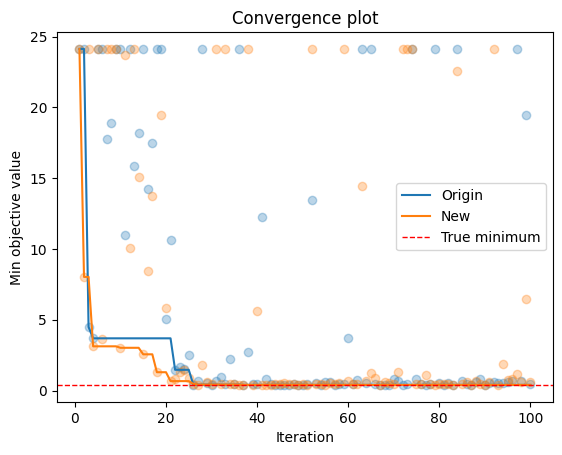

In [58]:
fig = plt.figure()
ax = fig.gca()
history.plot_convergence(ax=ax, color='C0', name='Origin')
history_new.plot_convergence(ax=ax, color='C1', name='New')

ax.axhline(problem.optimal_value, linestyle="--", color="r", lw=1, label="True minimum")
ax.legend()
plt.show()